#### Importing Libraries

In [1]:
import glob
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import tensorflow as tf
from threading import Thread
import time
from tqdm import tqdm
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, \
Dense, Input, Layer
import requests
from io import BytesIO
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

#### Reading files

In [2]:
path = r"E:\download 2\data\fashion-dataset/"
dirs_names = os.listdir(path)
dirs_names

['fashion-dataset', 'images', 'images.csv', 'styles', 'styles.csv']

In [3]:
styles_df = pd.read_csv(path + "styles.csv",error_bad_lines=False) 
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
print(styles_df.shape)
styles_df.head(5)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

(44424, 11)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName      image  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg

In [4]:
images_df = pd.read_csv(path + "images.csv")
print(images_df.shape)
images_df.head(5)

(44446, 2)


filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

#### Combining files

In [5]:
images_df['id'] = images_df['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)
images_df.head(5)

filename                                               link     id
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759

In [6]:
data = styles_df.merge(images_df,on='id',how='left').reset_index(drop=True)
data.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName      image  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg   
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg   
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg   
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg   

    filename                                               link  
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...  
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...  
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...  
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...  
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [7]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  44424 Number of features/variables: 13


#### Data Understanding

In [8]:
data.describe()

id          year
count  44424.000000  44423.000000
mean   29696.334301   2012.806497
std    17049.490518      2.126480
min     1163.000000   2007.000000
25%    14768.750000   2011.000000
50%    28618.500000   2012.000000
75%    44683.250000   2015.000000
max    60000.000000   2019.000000

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
 10  image               44424 non-null  object 
 11  filename            44424 non-null  object 
 12  link                44424 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 4.4+ MB


#### Adding image path to the data

In [10]:
data['filename'] = data['filename'].apply(lambda x: os.path.join(path + "images/",x))

In [11]:
data

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName      image  \
0                     Turtle Check Men Navy Blue Shirt  15970.jpg   
1                   Peter England Men Party Blue Jeans  39386.jpg   
2                             Titan Women Silver Watch  59263.jpg   
3        Manchester United Men Solid Black Track Pants  21379.jpg   
4                                Puma Men Grey T-shirt  53759.jpg   
...                                                ...        ...   
44419                        Gas Men Caddy Casual Shoe  17036.jpg   
44420               Lotto Men's Soccer Track Flip Flop   6461.jpg   
44421             Puma Men Graphic Stellar Blue Tshirt  18842.jpg   
44422                   Rasasi Women Blue Lady Perfume  46694.jpg   
44423  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg   

                                                filename  \
0      E:\download 2\data\fashion-dataset/images/1597...   
1      E:\download 2\data\fashion-dataset/images/3938...   
2      E:\download 2\data\fashion-dataset/images/5926...   
3      E:\download 2\data\fashion-dataset/images/2137...   
4      E:\download 2\data\fashion-dataset/images/5375...   
...                                                  ...   
44419  E:\download 2\data\fashion-dataset/images/1703...   
44420  E:\download 2\data\fashion-dataset/images/6461...   
44421  E:\download 2\data\fashion-dataset/images/1884...   
44422  E:\download 2\data\fashion-dataset/images/4669...   
44423  E:\download 2\data\fashion-dataset/images/5162...   

                                                    link  
0      http://assets.myntassets.com/v1/images/style/p...  
1      http://assets.myntassets.com/v1/images/style/p...  
2      http://assets.myntassets.com/v1/images/style/p...  
3      http://assets.myntassets.com/v1/images/style/p...  
4      http://assets.myntassets.com/v1/images/style/p...  
...                                                  ...  
44419  http://assets.myntassets.com/v1/images/style/p...  
44420  http://assets.myntassets.com/v1/images/style/p...  
44421  http://assets.myntassets.com/v1/images/style/p...  
44422  http://assets.myntassets.com/v1/images/style/p...  
44423  http://assets.myntassets.com/assets/images/516...  

[44424 rows x 13 columns]

#### Checking whether the image of a product is present in the folder or not

In [12]:
image_files = os.listdir(path + "images")
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)
data = data[data['file_found']].reset_index(drop=True)

In [13]:
data

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44414  17036    Men       Footwear       Shoes           Casual Shoes   
44415   6461    Men       Footwear  Flip Flops             Flip Flops   
44416  18842    Men        Apparel     Topwear                Tshirts   
44417  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44418  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44414      White  Summer  2013.0  Casual   
44415        Red  Summer  2011.0  Casual   
44416       Blue    Fall  2011.0  Casual   
44417       Blue  Spring  2017.0  Casual   
44418       Pink  Winter  2016.0  Casual   

                                    productDisplayName      image  \
0                     Turtle Check Men Navy Blue Shirt  15970.jpg   
1                   Peter England Men Party Blue Jeans  39386.jpg   
2                             Titan Women Silver Watch  59263.jpg   
3        Manchester United Men Solid Black Track Pants  21379.jpg   
4                                Puma Men Grey T-shirt  53759.jpg   
...                                                ...        ...   
44414                        Gas Men Caddy Casual Shoe  17036.jpg   
44415               Lotto Men's Soccer Track Flip Flop   6461.jpg   
44416             Puma Men Graphic Stellar Blue Tshirt  18842.jpg   
44417                   Rasasi Women Blue Lady Perfume  46694.jpg   
44418  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg   

                                                filename  \
0      E:\download 2\data\fashion-dataset/images/1597...   
1      E:\download 2\data\fashion-dataset/images/3938...   
2      E:\download 2\data\fashion-dataset/images/5926...   
3      E:\download 2\data\fashion-dataset/images/2137...   
4      E:\download 2\data\fashion-dataset/images/5375...   
...                                                  ...   
44414  E:\download 2\data\fashion-dataset/images/1703...   
44415  E:\download 2\data\fashion-dataset/images/6461...   
44416  E:\download 2\data\fashion-dataset/images/1884...   
44417  E:\download 2\data\fashion-dataset/images/4669...   
44418  E:\download 2\data\fashion-dataset/images/5162...   

                                                    link  file_found  
0      http://assets.myntassets.com/v1/images/style/p...        True  
1      http://assets.myntassets.com/v1/images/style/p...        True  
2      http://assets.myntassets.com/v1/images/style/p...        True  
3      http://assets.myntassets.com/v1/images/style/p...        True  
4      http://assets.myntassets.com/v1/images/style/p...        True  
...                                                  ...         ...  
44414  http://assets.myntassets.com/v1/images/style/p...        True  
44415  http://assets.myntassets.com/v1/images/style/p...        True  
44416  http://assets.myntassets.com/v1/images/style/p...        True  
44417  http://assets.myntassets.com/v1/images/style/p...        True  
44418  http://assets.myntassets.com/assets/images/516...        True  

[44419 rows x 14 columns]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44419 entries, 0 to 44418
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44419 non-null  int64  
 1   gender              44419 non-null  object 
 2   masterCategory      44419 non-null  object 
 3   subCategory         44419 non-null  object 
 4   articleType         44419 non-null  object 
 5   baseColour          44404 non-null  object 
 6   season              44398 non-null  object 
 7   year                44418 non-null  float64
 8   usage               44102 non-null  object 
 9   productDisplayName  44412 non-null  object 
 10  image               44419 non-null  object 
 11  filename            44419 non-null  object 
 12  link                44419 non-null  object 
 13  file_found          44419 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 4.4+ MB


In [15]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
image                   0
filename                0
link                    0
file_found              0
dtype: int64

In [16]:
data = data.dropna()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44072 entries, 0 to 44418
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44072 non-null  int64  
 1   gender              44072 non-null  object 
 2   masterCategory      44072 non-null  object 
 3   subCategory         44072 non-null  object 
 4   articleType         44072 non-null  object 
 5   baseColour          44072 non-null  object 
 6   season              44072 non-null  object 
 7   year                44072 non-null  float64
 8   usage               44072 non-null  object 
 9   productDisplayName  44072 non-null  object 
 10  image               44072 non-null  object 
 11  filename            44072 non-null  object 
 12  link                44072 non-null  object 
 13  file_found          44072 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 4.7+ MB


In [18]:
data.drop(columns=['file_found',"image"],inplace=True)
data

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44414  17036    Men       Footwear       Shoes           Casual Shoes   
44415   6461    Men       Footwear  Flip Flops             Flip Flops   
44416  18842    Men        Apparel     Topwear                Tshirts   
44417  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44418  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44414      White  Summer  2013.0  Casual   
44415        Red  Summer  2011.0  Casual   
44416       Blue    Fall  2011.0  Casual   
44417       Blue  Spring  2017.0  Casual   
44418       Pink  Winter  2016.0  Casual   

                                    productDisplayName  \
0                     Turtle Check Men Navy Blue Shirt   
1                   Peter England Men Party Blue Jeans   
2                             Titan Women Silver Watch   
3        Manchester United Men Solid Black Track Pants   
4                                Puma Men Grey T-shirt   
...                                                ...   
44414                        Gas Men Caddy Casual Shoe   
44415               Lotto Men's Soccer Track Flip Flop   
44416             Puma Men Graphic Stellar Blue Tshirt   
44417                   Rasasi Women Blue Lady Perfume   
44418  Fossil Women Pink Dial Chronograph Watch ES3050   

                                                filename  \
0      E:\download 2\data\fashion-dataset/images/1597...   
1      E:\download 2\data\fashion-dataset/images/3938...   
2      E:\download 2\data\fashion-dataset/images/5926...   
3      E:\download 2\data\fashion-dataset/images/2137...   
4      E:\download 2\data\fashion-dataset/images/5375...   
...                                                  ...   
44414  E:\download 2\data\fashion-dataset/images/1703...   
44415  E:\download 2\data\fashion-dataset/images/6461...   
44416  E:\download 2\data\fashion-dataset/images/1884...   
44417  E:\download 2\data\fashion-dataset/images/4669...   
44418  E:\download 2\data\fashion-dataset/images/5162...   

                                                    link  
0      http://assets.myntassets.com/v1/images/style/p...  
1      http://assets.myntassets.com/v1/images/style/p...  
2      http://assets.myntassets.com/v1/images/style/p...  
3      http://assets.myntassets.com/v1/images/style/p...  
4      http://assets.myntassets.com/v1/images/style/p...  
...                                                  ...  
44414  http://assets.myntassets.com/v1/images/style/p...  
44415  http://assets.myntassets.com/v1/images/style/p...  
44416  http://assets.myntassets.com/v1/images/style/p...  
44417  http://assets.myntassets.com/v1/images/style/p...  
44418  http://assets.myntassets.com/assets/images/516...  

[44072 rows x 12 columns]

#### Data Analysis

In [19]:
print(sum(data.duplicated('productDisplayName')))

13271


In [20]:
data_sorted = data[data['productDisplayName'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 36522


In [21]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('productDisplayName',inplace=True, ascending=False)
data_sorted.head()

id gender masterCategory subCategory articleType baseColour  season  \
24356  20058  Women        Apparel  Bottomwear   Stockings       Grey    Fall   
29008   7019  Women        Apparel     Topwear        Tops      White  Summer   
34897   6929  Women        Apparel     Topwear     Tshirts      Brown  Summer   
5562    6953  Women        Apparel     Topwear        Tops       Blue  Summer   
33896   6987  Women        Apparel     Topwear        Tops       Blue  Summer   

         year   usage                          productDisplayName  \
24356  2011.0  Casual  united Colors Of Benetton Women Grey Tight   
29008  2011.0  Casual           s.Oliver Women's White Blouse Top   
34897  2011.0  Casual             s.Oliver Women's Tank Brown Top   
5562   2011.0  Casual     s.Oliver Women's Striped Light Blue Top   
33896  2011.0  Casual               s.Oliver Women's Sky Blue Top   

                                                filename  \
24356  E:\download 2\data\fashion-dataset/images/2005...   
29008  E:\download 2\data\fashion-dataset/images/7019...   
34897  E:\download 2\data\fashion-dataset/images/6929...   
5562   E:\download 2\data\fashion-dataset/images/6953...   
33896  E:\download 2\data\fashion-dataset/images/6987...   

                                                    link  
24356  http://assets.myntassets.com/v1/images/style/p...  
29008  http://assets.myntassets.com/v1/images/style/p...  
34897  http://assets.myntassets.com/v1/images/style/p...  
5562   http://assets.myntassets.com/v1/images/style/p...  
33896  http://assets.myntassets.com/v1/images/style/p...

In [22]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
    import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:    
    previous_i = i
    a = data['productDisplayName'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:
        b = data['productDisplayName'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1 
        if (length - count) > 2: 
            stage1_dedupe_asins.append(data_sorted['id'].loc[indices[i]])
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [23]:
data = data.loc[data['id'].isin(stage1_dedupe_asins)]

In [24]:
print('Number of data points : ', data.shape[0])

Number of data points :  16598


In [25]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['id'].loc[i])
    a = data['productDisplayName'].loc[i].split()
    for j in indices:       
        b = data['productDisplayName'].loc[j].split()        
        length = max(len(a),len(b))        
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1
        if (length - count) < 3:
            indices.remove(j)

In [26]:
data = data.loc[data['id'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])

Number of data points after stage two of dedupe:  8585


In [27]:
data.head()

id gender masterCategory subCategory articleType baseColour  season  \
11  48123  Women    Accessories       Belts       Belts      Black  Summer   
14  46885   Boys       Footwear  Flip Flops  Flip Flops  Navy Blue    Fall   
18  51832  Women        Apparel   Innerwear         Bra      Beige  Summer   
26  48311  Women    Accessories   Jewellery    Bracelet     Bronze  Winter   
28  56019  Women  Personal Care        Lips    Lipstick      Brown  Spring   

      year   usage                                 productDisplayName  \
11  2012.0  Casual             Fossil Women Black Huarache Weave Belt   
14  2012.0  Casual                     Ben 10 Boys Navy Blue Slippers   
18  2016.0  Casual               Bwitch Beige Full-Coverage Bra BW335   
26  2012.0  Casual               Pitaraa Women Bronze Beaded Bracelet   
28  2017.0  Casual  Colorbar Soft Touch Show Stopper Copper Lipsti...   

                                             filename  \
11  E:\download 2\data\fashion-dataset/images/4812...   
14  E:\download 2\data\fashion-dataset/images/4688...   
18  E:\download 2\data\fashion-dataset/images/5183...   
26  E:\download 2\data\fashion-dataset/images/4831...   
28  E:\download 2\data\fashion-dataset/images/5601...   

                                                 link  
11  http://assets.myntassets.com/v1/images/style/p...  
14  http://assets.myntassets.com/v1/images/style/p...  
18  http://assets.myntassets.com/v1/image/style/pr...  
26  http://assets.myntassets.com/v1/images/style/p...  
28  http://assets.myntassets.com/assets/images/560...

In [28]:
data.shape

(8585, 12)

### Recommendation using product display name
#### BOW

In [29]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'by', 'until', 'won', 'where', 'hadn', "hasn't", 'during', 'them', 'has', 'there', 'below', 'over', 'does', 've', 'too', 'ma', 'ourselves', 'up', 'nor', 'other', 'some', 'is', 'here', 'couldn', 'ain', 'those', 'very', 'for', "doesn't", 'if', 'before', 'with', 'him', 'but', 'don', 'ours', "aren't", "weren't", 'haven', 'its', "it's", 'above', 'to', 'being', "should've", 'doesn', 'needn', "that'll", 'had', 'only', 'of', 'theirs', 'having', 'yourself', 'when', 'against', 'just', 'can', 'more', 'on', 'shan', 'as', "mustn't", "wasn't", 'off', 'we', 'd', 'whom', 'any', 'from', 'now', "mightn't", 'mustn', 'she', 'few', 'this', 'further', 'a', 'itself', 'same', 'so', 'because', "she's", 'were', 'such', "you'd", 'all', 'most', 't', 'which', 'why', 'didn', 'been', 'own', 'after', 'between', 'myself', "haven't", 'they', 'both', 'her', 're', 'not', 'aren', 'your', 'our', "couldn't", 'at', "you're", 'under', 'who', 'no', "isn't", 'weren', "don't", 'it', 'once', 'their', 'my', 'i

In [30]:
for index, row in data.iterrows():
    nlp_preprocessing(row['productDisplayName'], index, 'productDisplayName')

In [31]:
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
  


def plot_heatmap(keys, values, labels, url, text):
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
    ax.set_xticklabels(keys) 
    ax.set_title(text) 
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):    
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
    
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)

def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['productDisplayName'])
title_features.get_shape()

(8585, 5693)

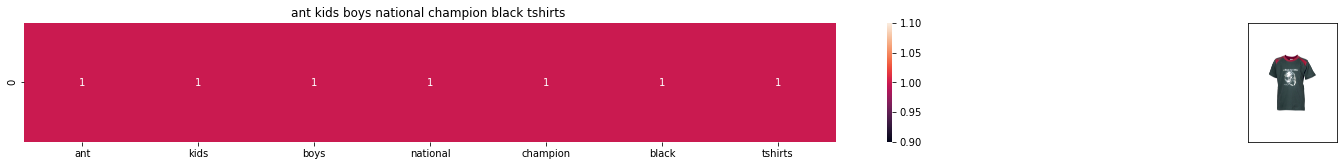

ID : 12847
masterCategory: Apparel
Title: ant kids boys national champion black tshirts 
Euclidean similarity with the query image : 0.0


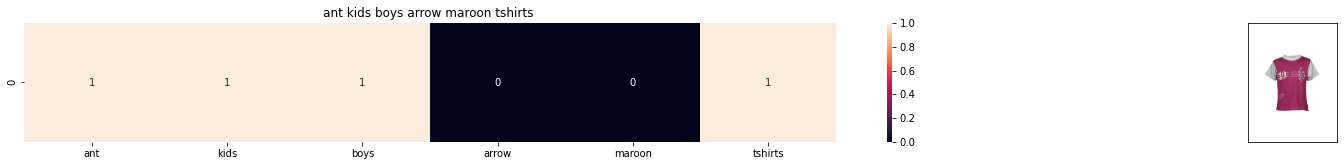

ID : 12845
masterCategory: Apparel
Title: ant kids boys arrow maroon tshirts 
Euclidean similarity with the query image : 2.23606797749979


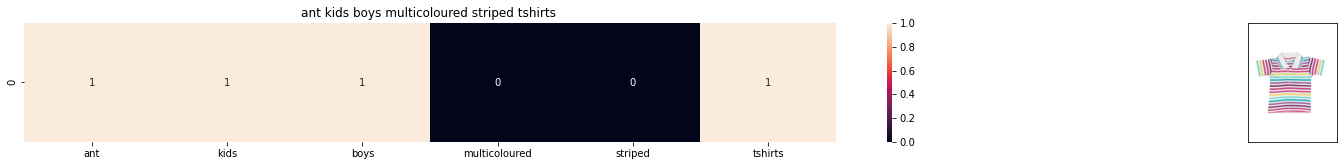

ID : 12844
masterCategory: Apparel
Title: ant kids boys multicoloured striped tshirts 
Euclidean similarity with the query image : 2.23606797749979


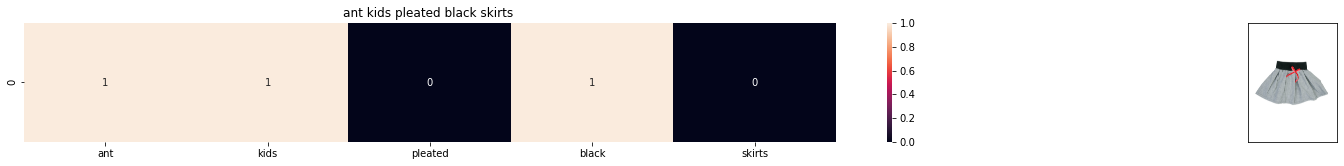

ID : 12839
masterCategory: Apparel
Title: ant kids pleated black skirts 
Euclidean similarity with the query image : 2.449489742783178


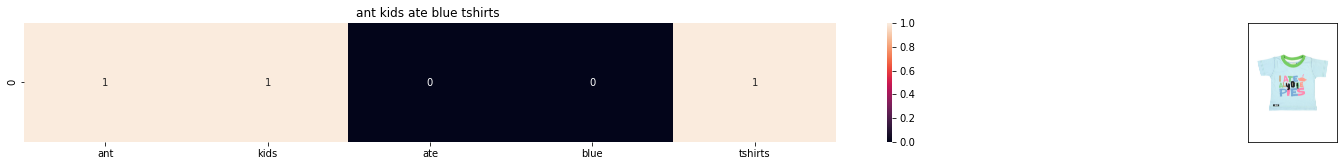

ID : 12832
masterCategory: Apparel
Title: ant kids ate blue tshirts 
Euclidean similarity with the query image : 2.449489742783178


In [33]:
from PIL import Image
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['productDisplayName'].loc[df_indices[0]], data['productDisplayName'].loc[df_indices[i]], data['link'].loc[df_indices[i]], 'bag_of_words')
        print('ID :',data['id'].loc[df_indices[i]])
        print ('masterCategory:', data['masterCategory'].loc[df_indices[i]])
        print ('Title:', data['productDisplayName'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

bag_of_words_model(931,5) 

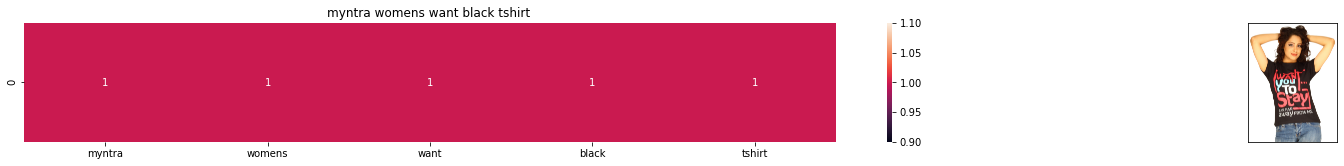

ID : 3534
masterCategory: Apparel
Title: myntra womens want black tshirt 
Euclidean similarity with the query image : 0.0


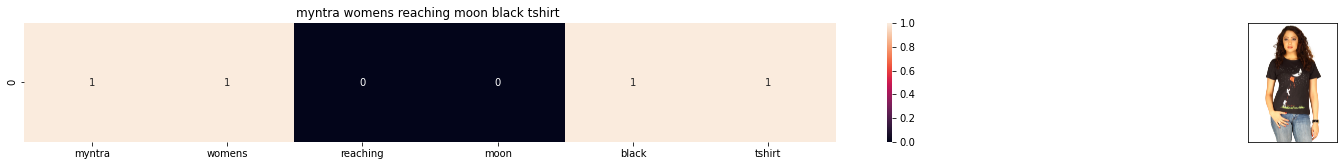

ID : 3522
masterCategory: Apparel
Title: myntra womens reaching moon black tshirt 
Euclidean similarity with the query image : 1.7320508075688772


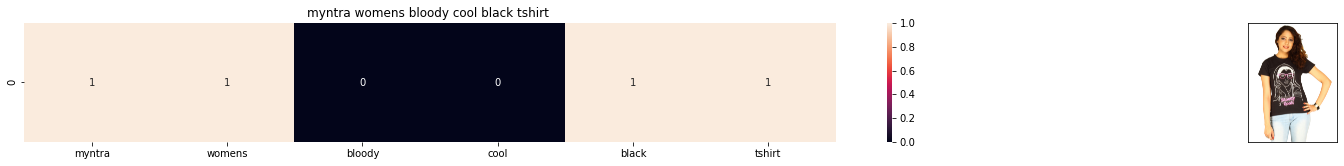

ID : 3537
masterCategory: Apparel
Title: myntra womens bloody cool black tshirt 
Euclidean similarity with the query image : 1.7320508075688772


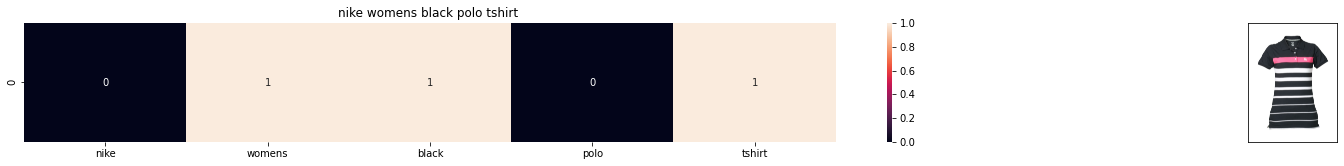

ID : 7512
masterCategory: Apparel
Title: nike womens black polo tshirt 
Euclidean similarity with the query image : 2.0


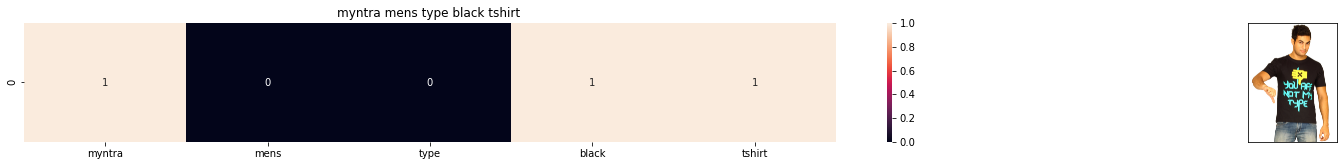

ID : 3346
masterCategory: Apparel
Title: myntra mens type black tshirt 
Euclidean similarity with the query image : 2.0


In [34]:
bag_of_words_model(91,5) 

#### TFIDF

In [35]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDisplayName'])

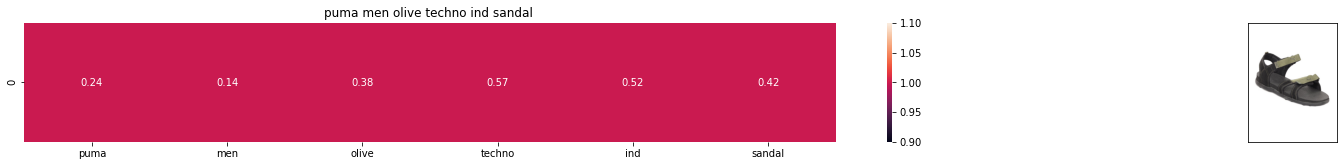

ID : 43958
masterCategory: Footwear
Title: puma men olive techno ind sandal 


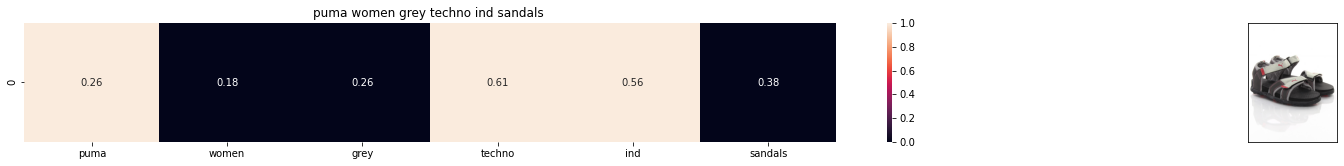

ID : 43957
masterCategory: Footwear
Title: puma women grey techno ind sandals 


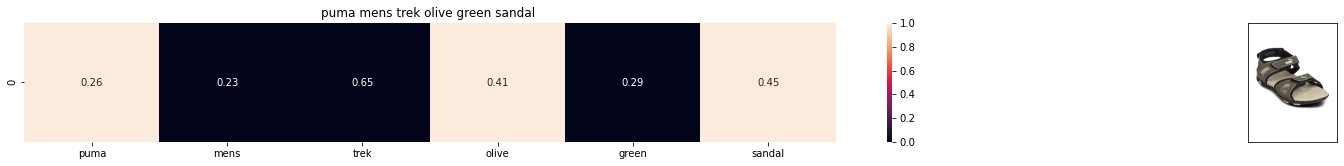

ID : 2224
masterCategory: Footwear
Title: puma mens trek olive green sandal 


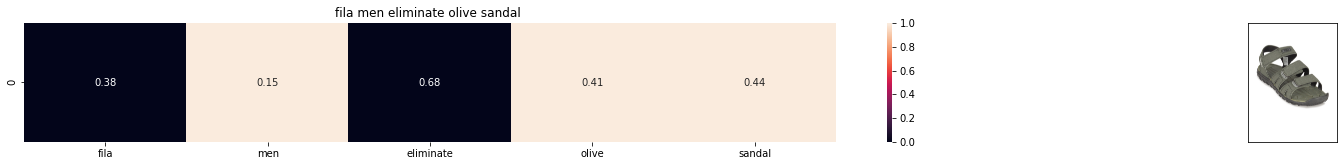

ID : 4103
masterCategory: Footwear
Title: fila men eliminate olive sandal 


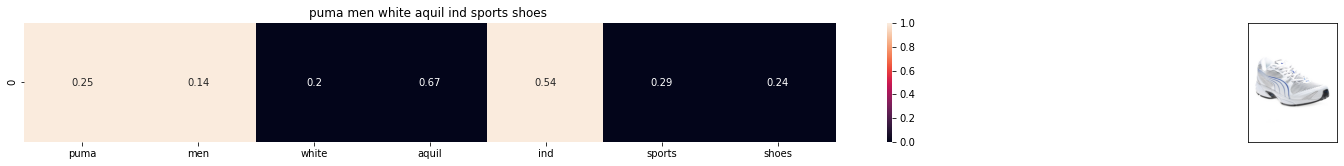

ID : 53873
masterCategory: Footwear
Title: puma men white aquil ind sports shoes 


In [36]:
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['productDisplayName'].loc[df_indices[0]], data['productDisplayName'].loc[df_indices[i]], data['link'].loc[df_indices[i]], 'tfidf')
        print('ID :',data['id'].loc[df_indices[i]])
        print ('masterCategory:', data['masterCategory'].loc[df_indices[i]])
        print ('Title:', data['productDisplayName'].loc[df_indices[i]])
        print('='*125)
tfidf_model(41,5)

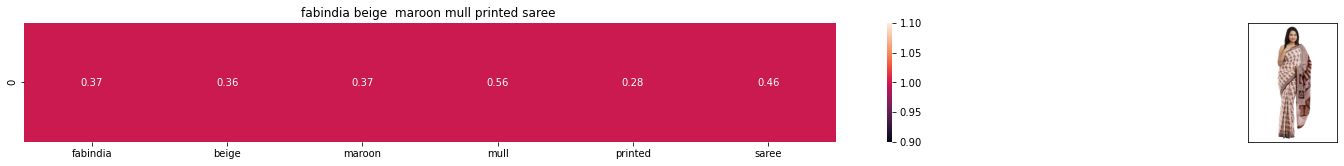

ID : 56684
masterCategory: Apparel
Title: fabindia beige  maroon mull printed saree 


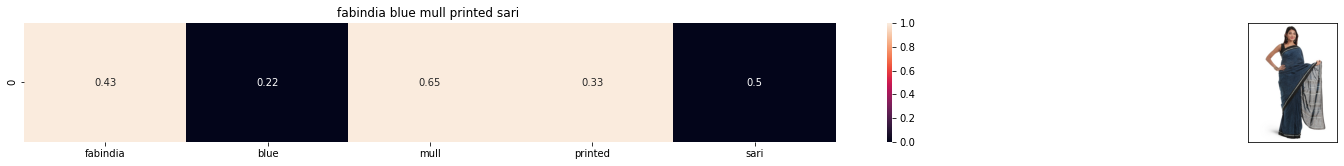

ID : 46007
masterCategory: Apparel
Title: fabindia blue mull printed sari 


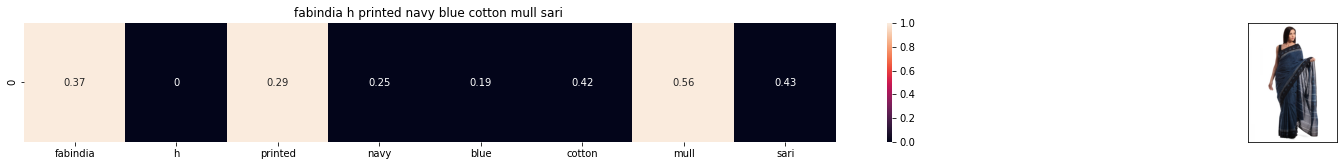

ID : 34992
masterCategory: Apparel
Title: fabindia h printed navy blue cotton mull sari 


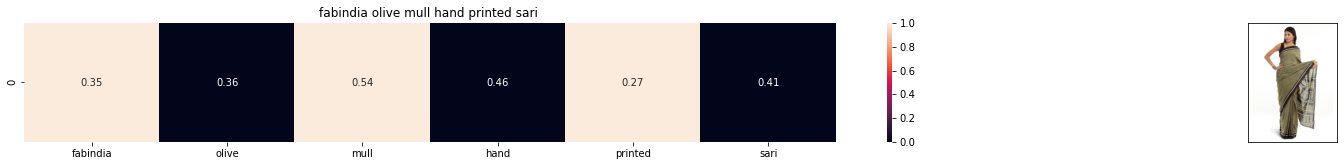

ID : 46009
masterCategory: Apparel
Title: fabindia olive mull hand printed sari 


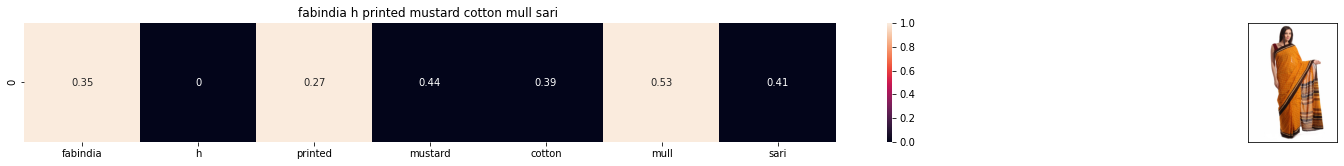

ID : 34994
masterCategory: Apparel
Title: fabindia h printed mustard cotton mull sari 


In [37]:
tfidf_model(44,5)

In [38]:
data.head()

id gender masterCategory subCategory articleType baseColour  season  \
11  48123  Women    Accessories       Belts       Belts      Black  Summer   
14  46885   Boys       Footwear  Flip Flops  Flip Flops  Navy Blue    Fall   
18  51832  Women        Apparel   Innerwear         Bra      Beige  Summer   
26  48311  Women    Accessories   Jewellery    Bracelet     Bronze  Winter   
28  56019  Women  Personal Care        Lips    Lipstick      Brown  Spring   

      year   usage                                 productDisplayName  \
11  2012.0  Casual            fossil women black huarache weave belt    
14  2012.0  Casual                    ben 10 boys navy blue slippers    
18  2016.0  Casual               bwitch beige fullcoverage bra bw335    
26  2012.0  Casual              pitaraa women bronze beaded bracelet    
28  2017.0  Casual  colorbar soft touch show stopper copper lipsti...   

                                             filename  \
11  E:\download 2\data\fashion-dataset/images/4812...   
14  E:\download 2\data\fashion-dataset/images/4688...   
18  E:\download 2\data\fashion-dataset/images/5183...   
26  E:\download 2\data\fashion-dataset/images/4831...   
28  E:\download 2\data\fashion-dataset/images/5601...   

                                                 link  
11  http://assets.myntassets.com/v1/images/style/p...  
14  http://assets.myntassets.com/v1/images/style/p...  
18  http://assets.myntassets.com/v1/image/style/pr...  
26  http://assets.myntassets.com/v1/images/style/p...  
28  http://assets.myntassets.com/assets/images/560...

In [39]:
data.drop(columns=['productDisplayName'],inplace=True)
data

id gender masterCategory subCategory            articleType  \
11     48123  Women    Accessories       Belts                  Belts   
14     46885   Boys       Footwear  Flip Flops             Flip Flops   
18     51832  Women        Apparel   Innerwear                    Bra   
26     48311  Women    Accessories   Jewellery               Bracelet   
28     56019  Women  Personal Care        Lips               Lipstick   
...      ...    ...            ...         ...                    ...   
44409  30614    Men        Apparel     Topwear                Tshirts   
44410  13496    Men        Apparel     Topwear                Tshirts   
44411  55283  Women  Personal Care      Makeup  Highlighter and Blush   
44415   6461    Men       Footwear  Flip Flops             Flip Flops   
44418  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
11         Black  Summer  2012.0  Casual   
14     Navy Blue    Fall  2012.0  Casual   
18         Beige  Summer  2016.0  Casual   
26        Bronze  Winter  2012.0  Casual   
28         Brown  Spring  2017.0  Casual   
...          ...     ...     ...     ...   
44409      Black  Summer  2012.0  Sports   
44410       Blue    Fall  2011.0  Casual   
44411       Pink  Spring  2017.0  Casual   
44415        Red  Summer  2011.0  Casual   
44418       Pink  Winter  2016.0  Casual   

                                                filename  \
11     E:\download 2\data\fashion-dataset/images/4812...   
14     E:\download 2\data\fashion-dataset/images/4688...   
18     E:\download 2\data\fashion-dataset/images/5183...   
26     E:\download 2\data\fashion-dataset/images/4831...   
28     E:\download 2\data\fashion-dataset/images/5601...   
...                                                  ...   
44409  E:\download 2\data\fashion-dataset/images/3061...   
44410  E:\download 2\data\fashion-dataset/images/1349...   
44411  E:\download 2\data\fashion-dataset/images/5528...   
44415  E:\download 2\data\fashion-dataset/images/6461...   
44418  E:\download 2\data\fashion-dataset/images/5162...   

                                                    link  
11     http://assets.myntassets.com/v1/images/style/p...  
14     http://assets.myntassets.com/v1/images/style/p...  
18     http://assets.myntassets.com/v1/image/style/pr...  
26     http://assets.myntassets.com/v1/images/style/p...  
28     http://assets.myntassets.com/assets/images/560...  
...                                                  ...  
44409  http://assets.myntassets.com/v1/images/style/p...  
44410  http://assets.myntassets.com/v1/images/style/p...  
44411  http://assets.myntassets.com/v1/images/style/p...  
44415  http://assets.myntassets.com/v1/images/style/p...  
44418  http://assets.myntassets.com/assets/images/516...  

[8585 rows x 11 columns]

#### Recommendation Using image of the product

In [40]:
data = data.sample(frac=1).reset_index(drop=True)
n = len(data)
train = data.iloc[:int(n*0.8),:]
val = data.iloc[int(n*0.8):,:].reset_index(drop=True)

In [41]:
val

id  gender masterCategory subCategory            articleType  \
0      3451     Men        Apparel     Topwear                Tshirts   
1     18889   Women        Apparel     Topwear                 Shirts   
2     56102   Women  Personal Care        Lips              Lip Gloss   
3     39233   Women        Apparel       Dress                Dresses   
4      6516  Unisex    Accessories        Bags              Backpacks   
...     ...     ...            ...         ...                    ...   
1712  27321   Women  Personal Care   Fragrance  Perfume and Body Mist   
1713  10649    Boys        Apparel     Topwear                 Shirts   
1714  50384   Women        Apparel  Bottomwear     Salwar and Dupatta   
1715   3309     Men       Footwear       Shoes           Sports Shoes   
1716   4032     Men        Apparel     Topwear                Tshirts   

     baseColour  season    year   usage  \
0         White    Fall  2010.0  Sports   
1          Blue    Fall  2011.0  Formal   
2        Maroon  Spring  2017.0  Casual   
3          Blue  Summer  2012.0  Casual   
4         Black  Summer  2011.0  Casual   
...         ...     ...     ...     ...   
1712       Pink  Spring  2017.0  Casual   
1713      White    Fall  2011.0  Casual   
1714      Black  Summer  2012.0  Ethnic   
1715      White  Spring  2012.0  Sports   
1716      Black  Summer  2011.0  Casual   

                                               filename  \
0     E:\download 2\data\fashion-dataset/images/3451...   
1     E:\download 2\data\fashion-dataset/images/1888...   
2     E:\download 2\data\fashion-dataset/images/5610...   
3     E:\download 2\data\fashion-dataset/images/3923...   
4     E:\download 2\data\fashion-dataset/images/6516...   
...                                                 ...   
1712  E:\download 2\data\fashion-dataset/images/2732...   
1713  E:\download 2\data\fashion-dataset/images/1064...   
1714  E:\download 2\data\fashion-dataset/images/5038...   
1715  E:\download 2\data\fashion-dataset/images/3309...   
1716  E:\download 2\data\fashion-dataset/images/4032...   

                                                   link  
0     http://assets.myntassets.com/v1/images/style/p...  
1     http://assets.myntassets.com/v1/images/style/p...  
2     http://assets.myntassets.com/assets/images/561...  
3     http://assets.myntassets.com/v1/images/style/p...  
4     http://assets.myntassets.com/v1/images/style/p...  
...                                                 ...  
1712  http://assets.myntassets.com/v1/images/style/p...  
1713  http://assets.myntassets.com/v1/images/style/p...  
1714  http://assets.myntassets.com/v1/images/style/p...  
1715  http://assets.myntassets.com/v1/images/style/p...  
1716  http://assets.myntassets.com/v1/images/style/p...  

[1717 rows x 11 columns]

In [42]:
datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_dataframe(dataframe=train,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

val_generator = datagen.flow_from_dataframe(dataframe=val,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

Found 6868 validated image filenames.
Found 1717 validated image filenames.


In [43]:
base_model = VGG16(include_top=False,input_shape=(256,256,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       2

In [44]:
train_features = model.predict(train_generator,verbose=1)
val_features = model.predict(val_generator,verbose=1)

54/54 [==============================] - 242s 4s/step


#### PCA

In [45]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(train_features)
train_pca = pca.transform(train_features)

In [46]:
test_pca = pca.fit_transform(val_features)

In [47]:
train_pca = pd.DataFrame(train_pca)
train = train.iloc[:,0:10]
train = train.merge(train_pca, how='left', left_index=True, right_index=True)

In [48]:
fig = px.scatter(train, x=0, y=1, color="masterCategory", title='Main Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [49]:
fig = px.scatter(train, x=0, y=1, color="gender", title='Gender', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [50]:
fig = px.scatter(train, x=0, y=1, color="subCategory", title='Sub Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [51]:
fig = px.scatter(train[train['season'].notna()], x=0, y=1, color="season", title='Season', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [52]:
fig = px.scatter(train[train['usage'].notna()], x=0, y=1, color="usage", title='Usage', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [53]:
pca = PCA()
pca.fit(train_features)
train_pca = pca.transform(train_features)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

In [54]:
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})

In [55]:
val_pca = pca.fit_transform(val_features)[:,:313]
val_pca = pd.DataFrame(val_pca)
val = val.iloc[:,0:10]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)

In [56]:
val.columns[:11]

Index([            'id',         'gender', 'masterCategory',    'subCategory',
          'articleType',     'baseColour',         'season',           'year',
                'usage',       'filename',                0],
      dtype='object')

#### Computing Similarities using KNN 

In [57]:
X = val.iloc[:,-313:]
y = val['id']

In [58]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=6)

In [59]:
def read_img(image_path):
    image = load_img(image_path,target_size=(256,256,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [60]:
val.columns[:20]

Index([            'id',         'gender', 'masterCategory',    'subCategory',
          'articleType',     'baseColour',         'season',           'year',
                'usage',       'filename',                0,                1,
                      2,                3,                4,                5,
                      6,                7,                8,                9],
      dtype='object')

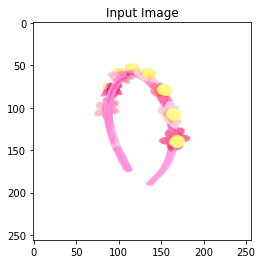

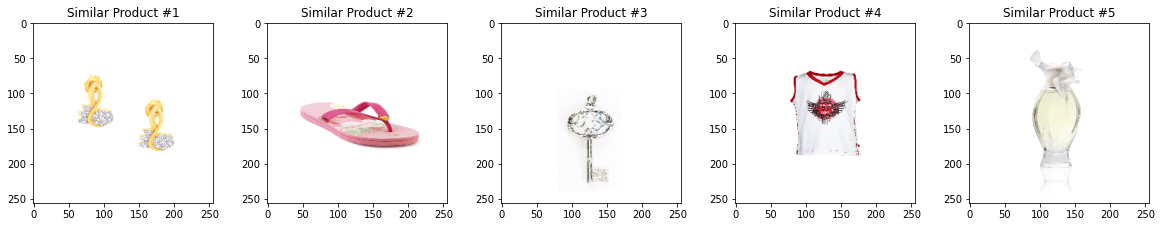

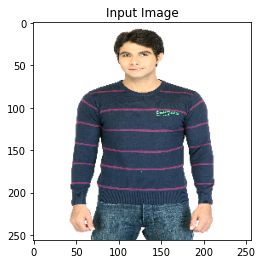

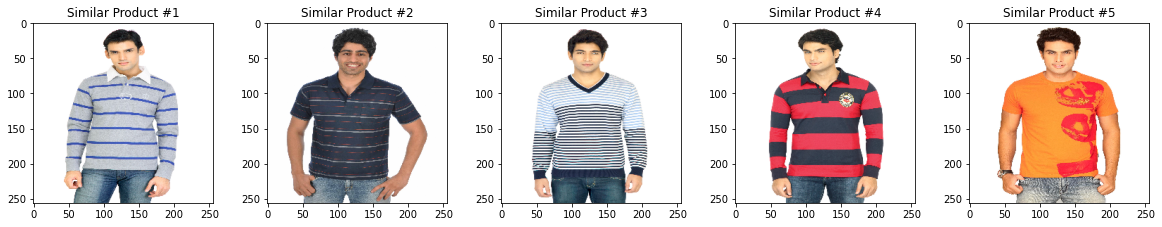

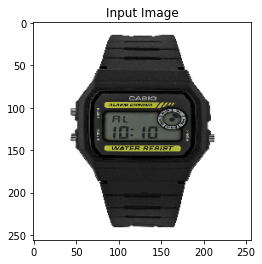

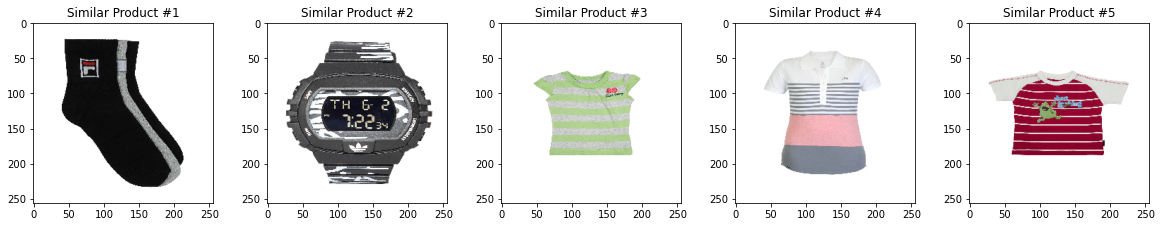

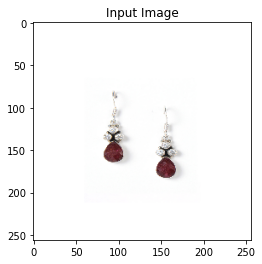

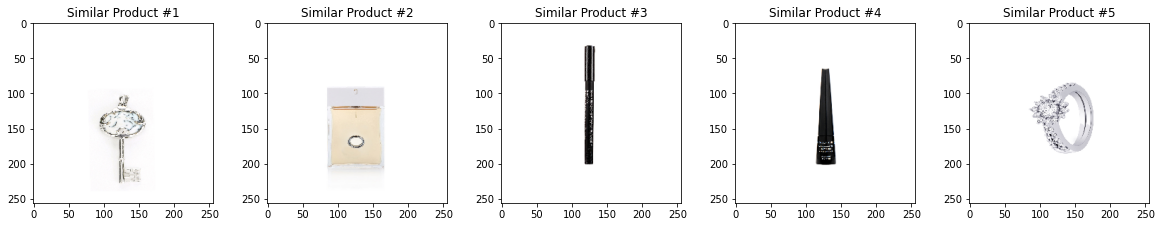

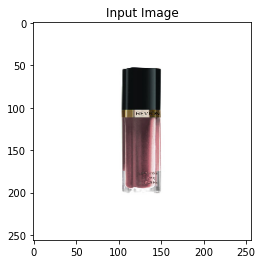

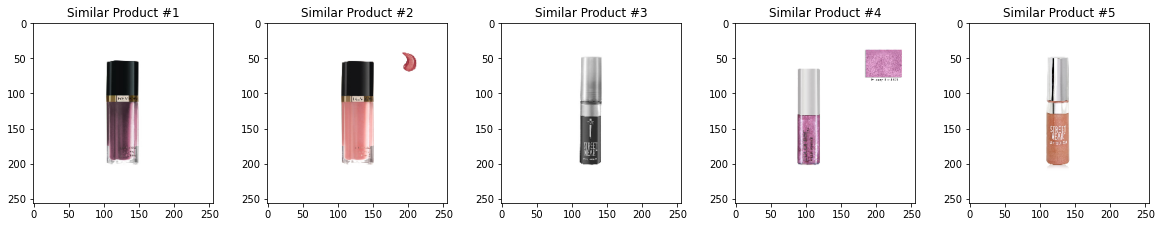

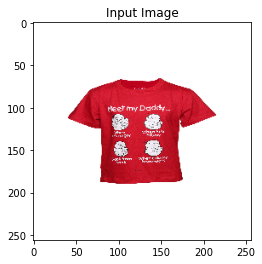

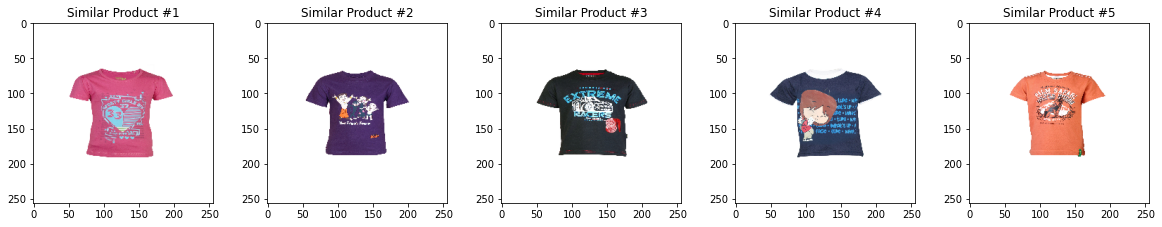

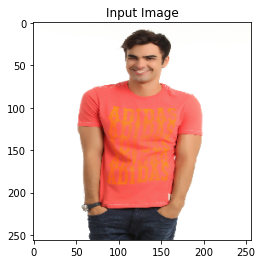

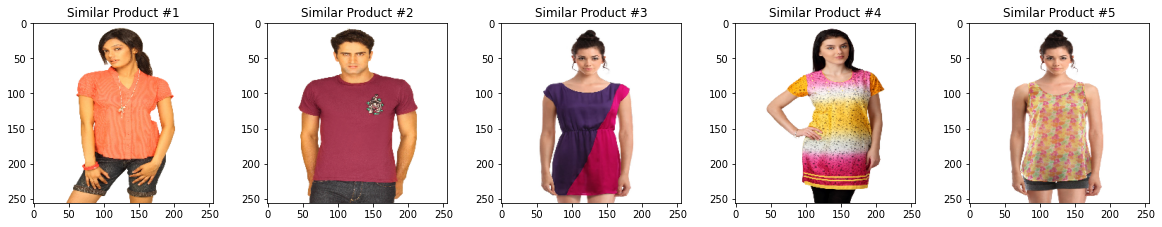

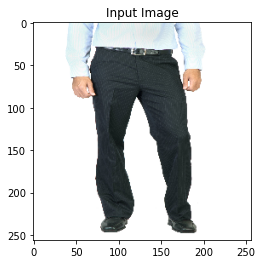

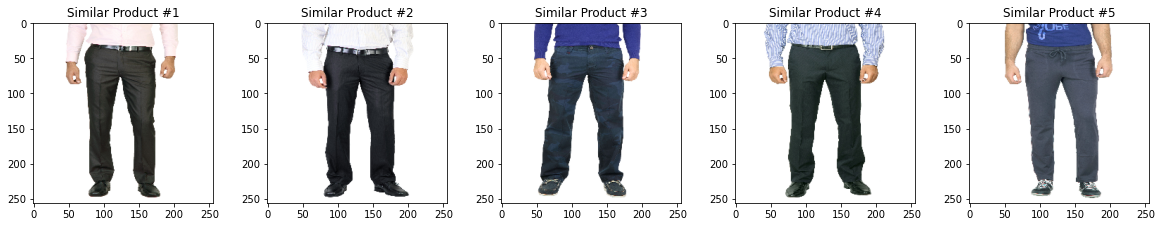

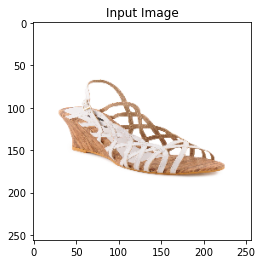

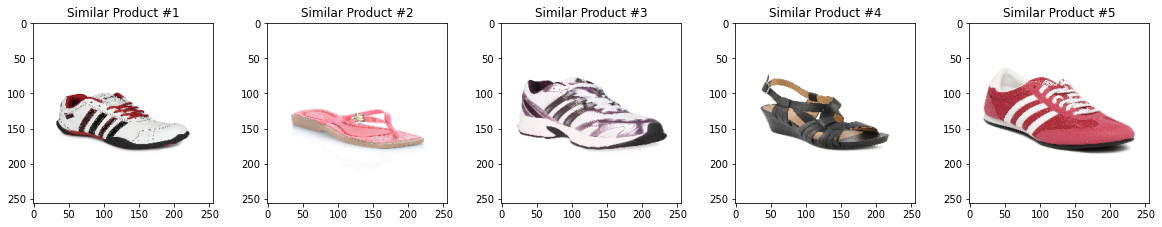

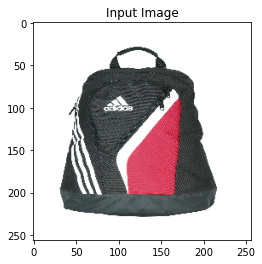

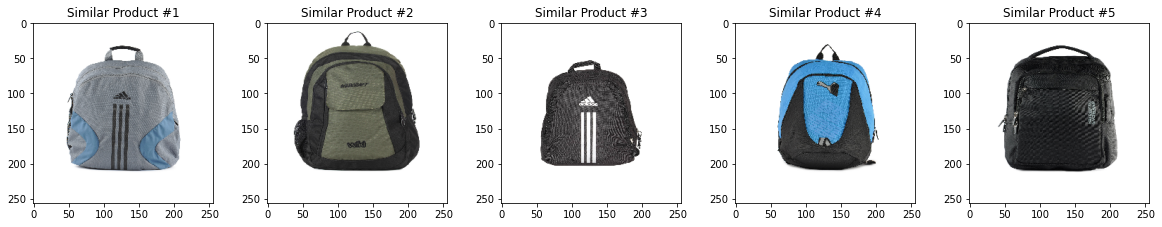

In [61]:
import random
for _ in range(10):
    i = random.randint(1,len(val))
    img1 = read_img(val.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(val.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')

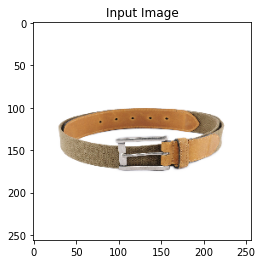

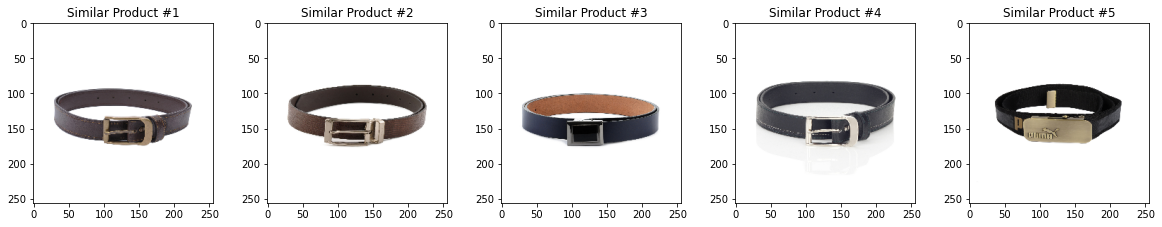

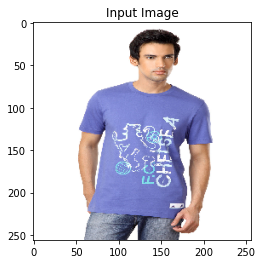

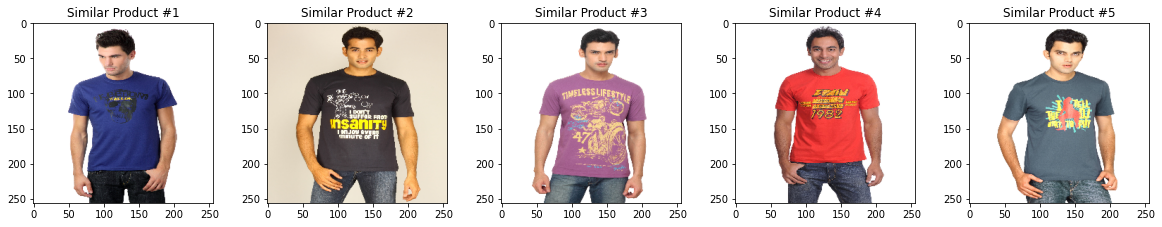

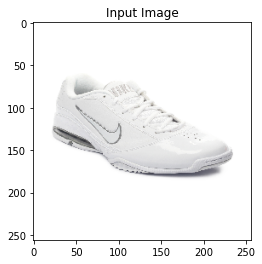

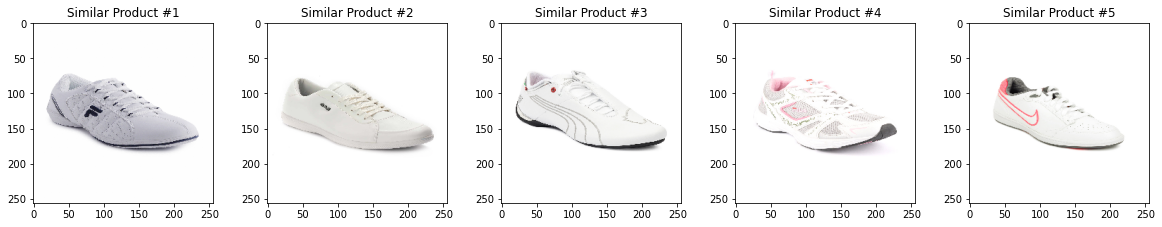

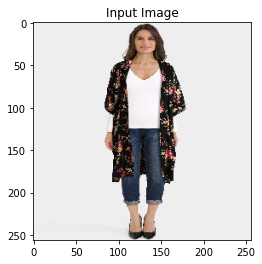

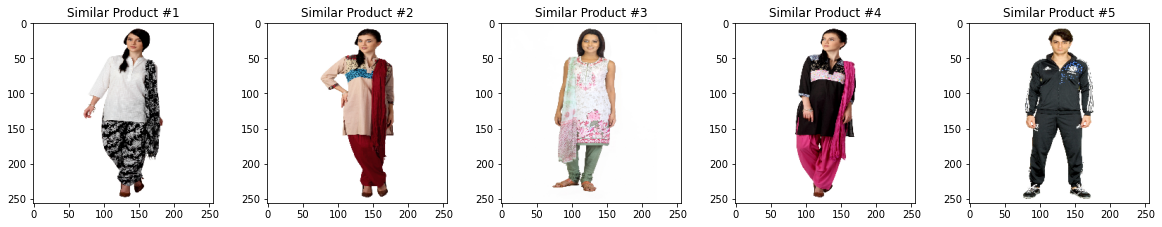

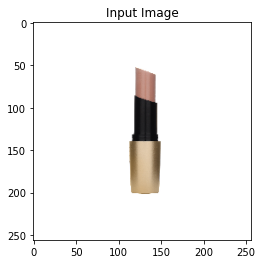

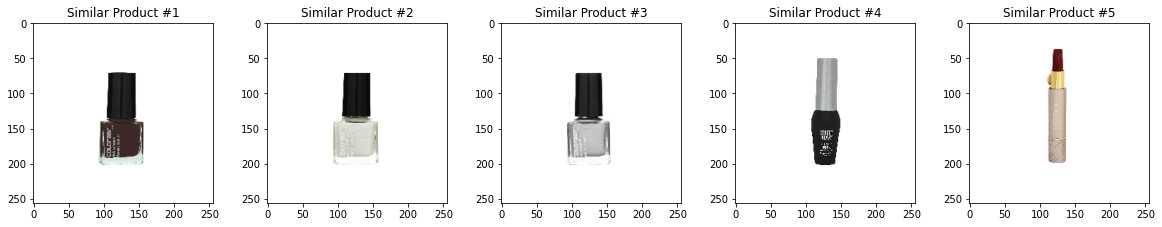

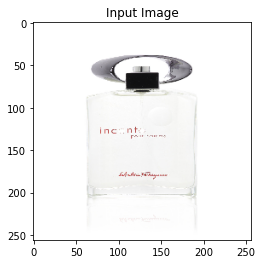

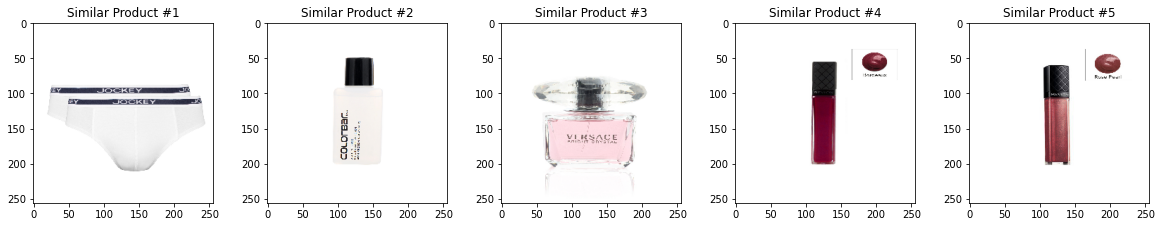

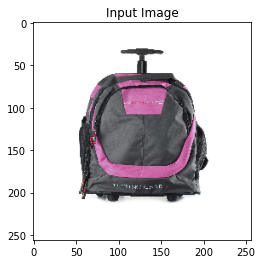

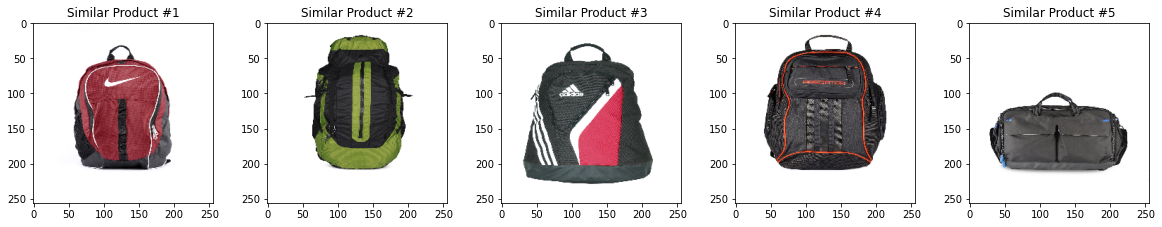

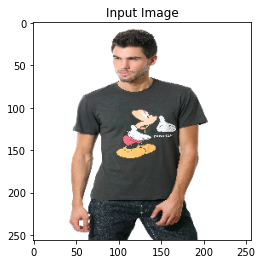

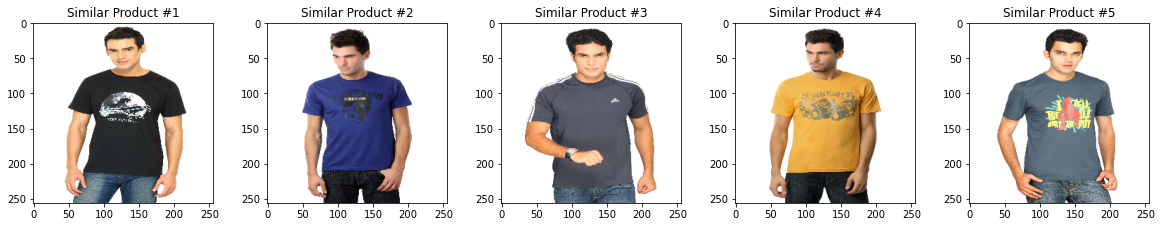

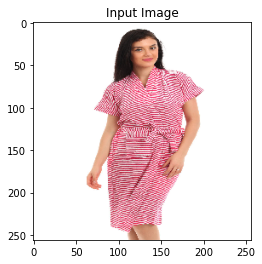

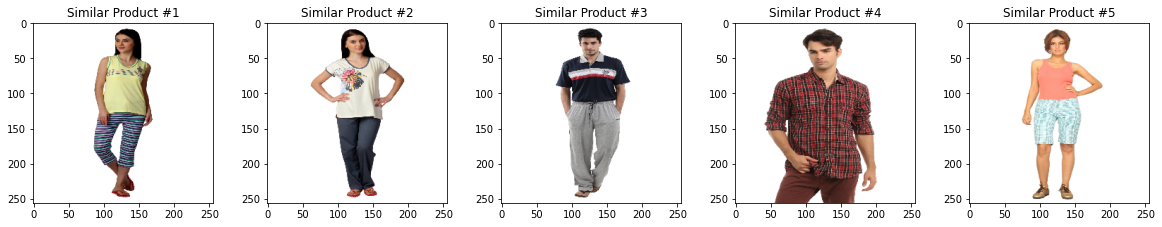

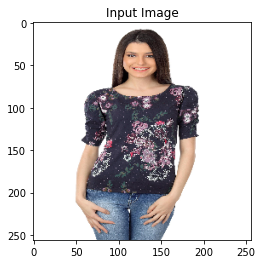

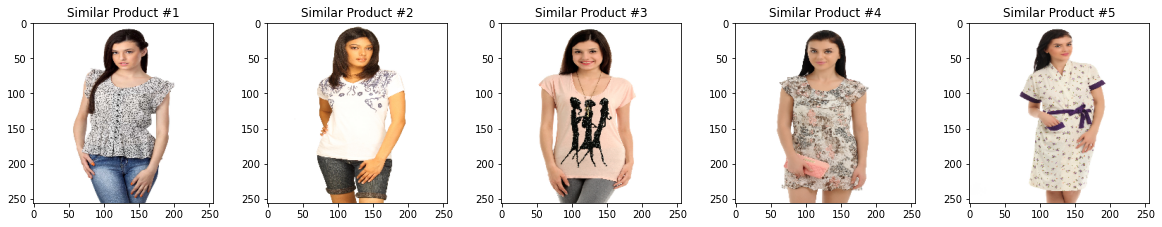

In [62]:
import random
for _ in range(10):
    i = random.randint(1,len(val))
    img1 = read_img(val.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(val.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')